# Applied Machine Learning with Scikit Learn - Regressions



### Libraries

- [scikit-learn](http://scikit-learn.org/stable/)




In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from scipy import stats
import seaborn as sns
import re
%matplotlib inline


## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

### Dataset description

614 samples with features:

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

In [4]:
lalonde = pd.read_csv('lalonde.csv', index_col=0)
lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

Let's description of the variable `re78`:

In [287]:
lalonde.groupby('treat')['re78'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,6984.169742,7294.161791,0.0,220.1813,4975.505,11688.820,25564.67
1,185.0,6349.143530,7867.402218,0.0,485.2298,4232.309,9642.999,60307.93


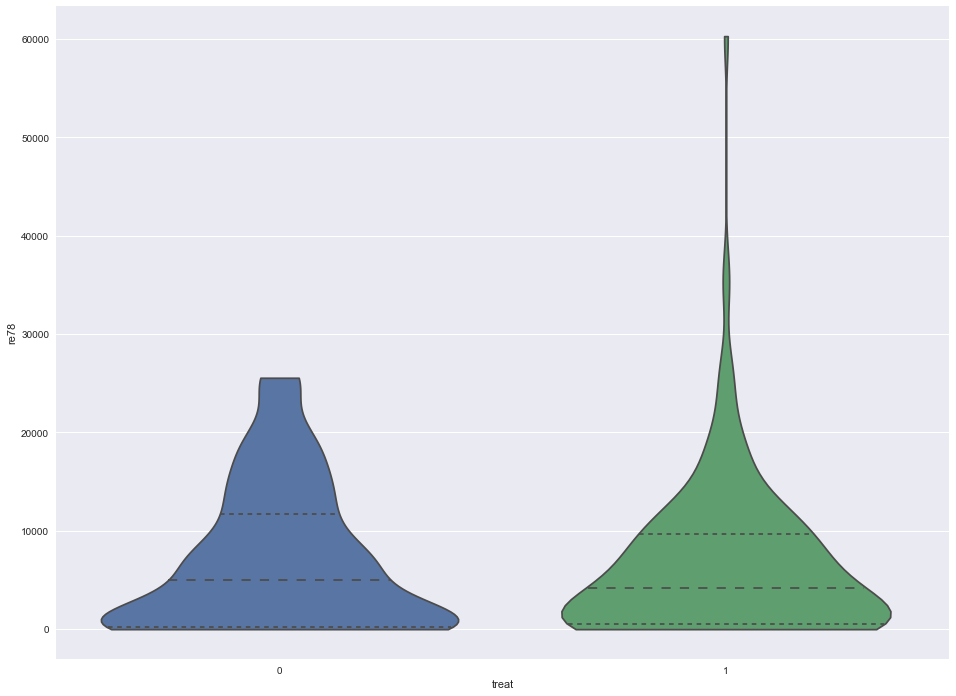

In [288]:
def plot_distribution(df,feature,title):
    """
    Plot the groups distribution of one feature in the dataframe df
    """
    f, ax = plt.subplots(1)
    f.set_size_inches(16, 8)
    #df = pd.melt(df[["treat","re74","re75","re78"]],
    #                              id_vars=["treat"],
    #                             value_vars=["re78"],
    #                            var_name='re_year',
    #                           value_name='re')
    
    #sns.violinplot(x="treat", y="re78", data=df,hue="treat",inner="quartile", split=True)
    
    #TODO coller les 2 cotés du violon
    # + title
    sns.violinplot(x="treat", y=feature, data=df,inner="quartile",cut=0,title=title)

plotDistribution(lalonde,'Real earning distribution in 1978')

This is interesting to see that the mean and the median is better for the control group in 1978. Even if the maximal earning is a subject from the treated group, it seams to be a outlier. We also can see that the last quartile is way higther for the control group. Does that mean that the treatment is not efficient? ;)

### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### Real earning distribution

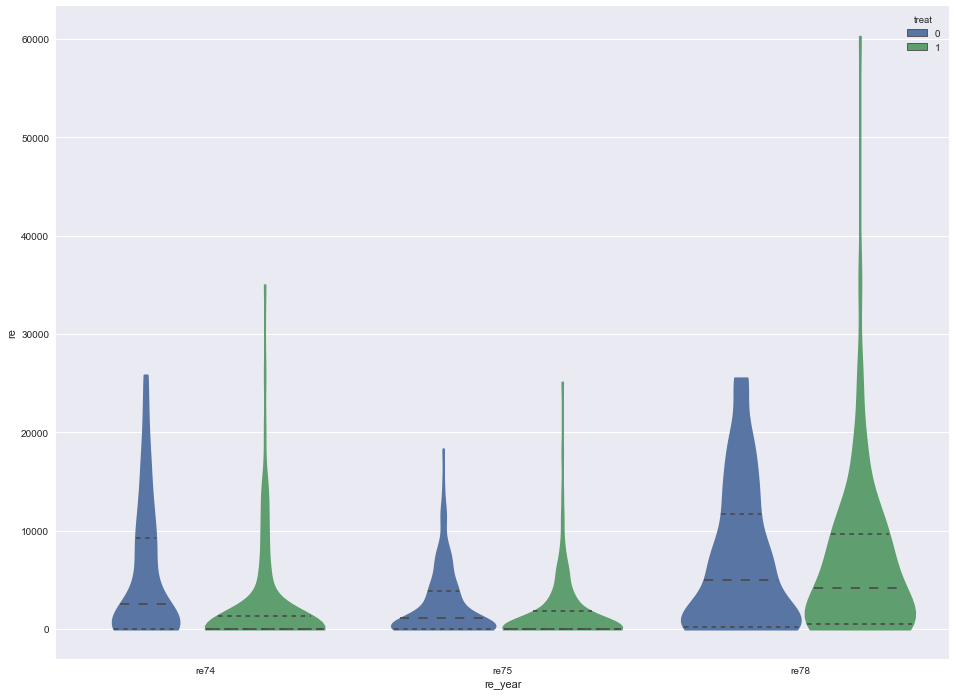

In [347]:
class RealEarning():  
    """
    Class to display the real earning distribution.
    """
    def __init__(self, df):
        self.df = df[["treat","re74","re75","re78"]]
        self.realEarning = pd.melt(df[["treat","re74","re75","re78"]],
                                   id_vars=['treat'],
                                   value_vars=["re74","re75","re78"],
                                   var_name='re_year',
                                   value_name='re')
        
    def plot_distribution(self):
        f,ax = plt.subplots(1)
        f.set_size_inches(16, 12)
        # We choose to use the violin visialization because the distribution in regrouped around zero
        sns.violinplot(x="re_year", y="re",hue="treat",cut=0,
                       title="Real earning distribution whitout unempoyed",
                       data=self.realEarning,inner="quartile")
        
    def plot_distribution_without_unemployed(self):
        f, ax = plt.subplots(1)
        f.set_size_inches(16, 12)
        df = self.realEarning.loc[self.realEarning.re != 0] 
        sns.violinplot(x="re_year", y="re",hue="treat",cut=0,
                       title="Real earning distribution whitout unempoyed",
                       data=df,inner="quartile")
        
    
real_earning = RealEarning(lalonde)
real_earning.plot_distribution()

The real earning distribution is realy different in 1974 and 1975. In the treated group, the median is around zero and 75% of group earn less than $3000 in 1974 and 1975. What is interesting to see is that for both group the real earning decrease in 1975 compared to 1974. We can explain that by the [73-75 recession](https://en.wikipedia.org/wiki/1973%E2%80%9375_recession).


### Unemployement
We think that is important to take a look at the umployement rate of the two groups.In order to do that, we assume that when you have no income, you are unemployed.

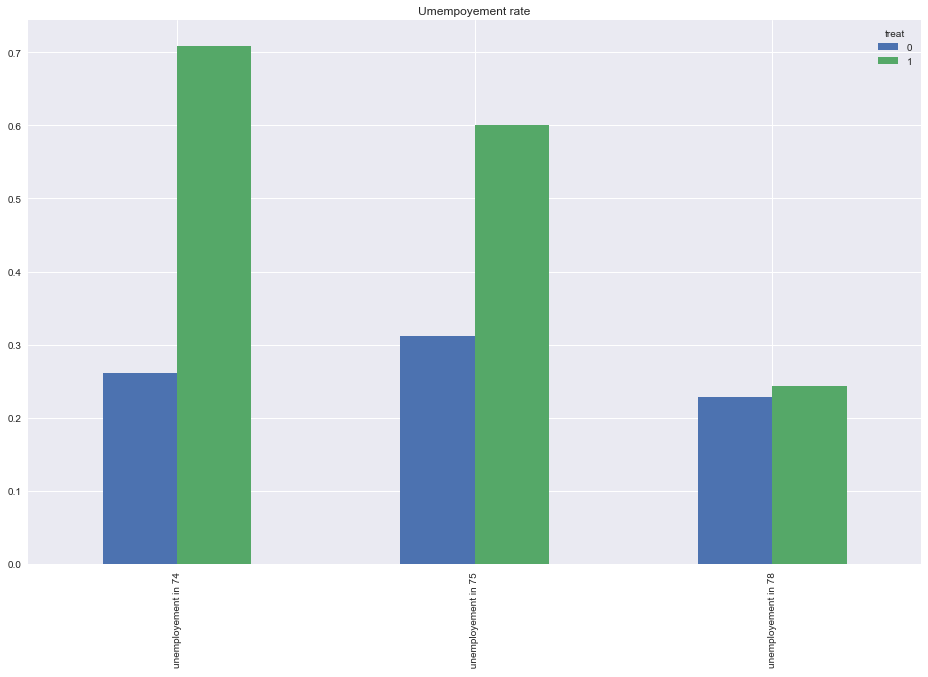

In [348]:
# function to commpute the unemployement rate.
# We assume that when you have no income, you are unemployed.
class Unemployement():  
    def __init__(self, df):
        total = df.groupby('treat').re78.count()
        unemployement74 = df.loc[df.re74==0].groupby('treat')["age"].count()/total
        unemployement75 = df.loc[df.re75==0].groupby('treat')["age"].count()/total
        unemployement78 = df.loc[df.re78==0].groupby('treat')["age"].count()/total
        self.unemployementRate = pd.DataFrame([unemployement74,unemployement75,unemployement78],
                                              ['unemployement in 74',' unemployement in 75','unemployement in 78'])
    def plot(self):
        figsize =(16,8)
        self.unemployementRate.plot(kind="bar",title="Umempoyement rate",figsize = figsize)
        
unemployement(lalonde).plot()

We can see that the distribution is very different in 1974 and 1975, when we look the unemployent rate. This explain the huge difference of earning between the two groups in 1974 and 1975.
#### Age distribution

In [317]:
lalonde.groupby('treat')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,28.030303,10.786653,16.0,19.0,25.0,35.0,55.0
1,185.0,25.816216,7.155019,17.0,20.0,25.0,29.0,48.0


We can see some differences in those two groups. The average and the variance are quite differents. Now let's take a look on the distribution.

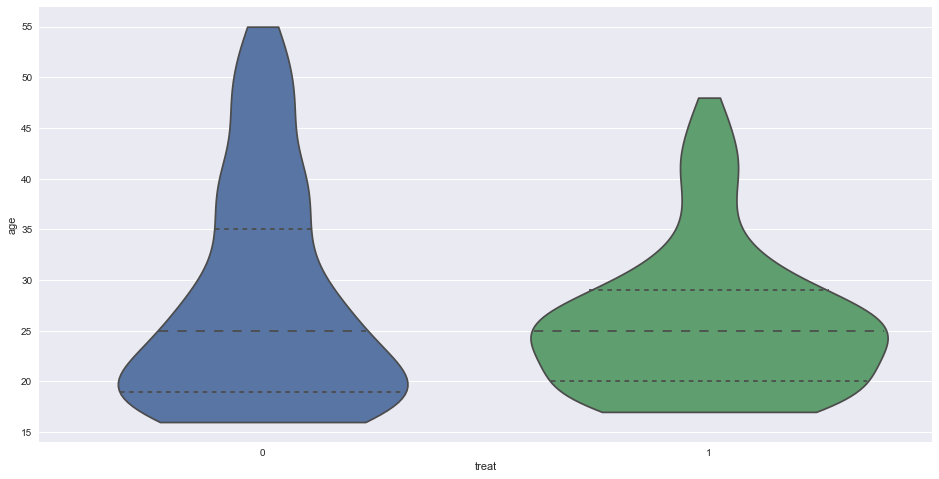

In [349]:
plot_distribution(lalonde,'age','Age distribution')

The age distribution for both classes is quite different. The distribution of the treated group is more centered around the median while the distribution of the control group is way more extanded. The treated group is youger that the control group and it could be an important metric in this study. We can expect that a young individual has more opportunity to raise is salary.
#### Categorical distributions
Let's plot all the categorical distribution together:

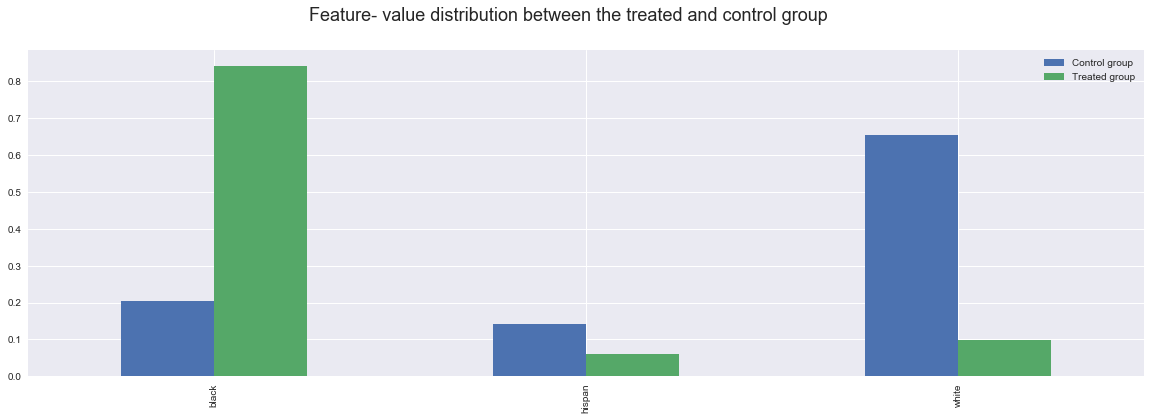

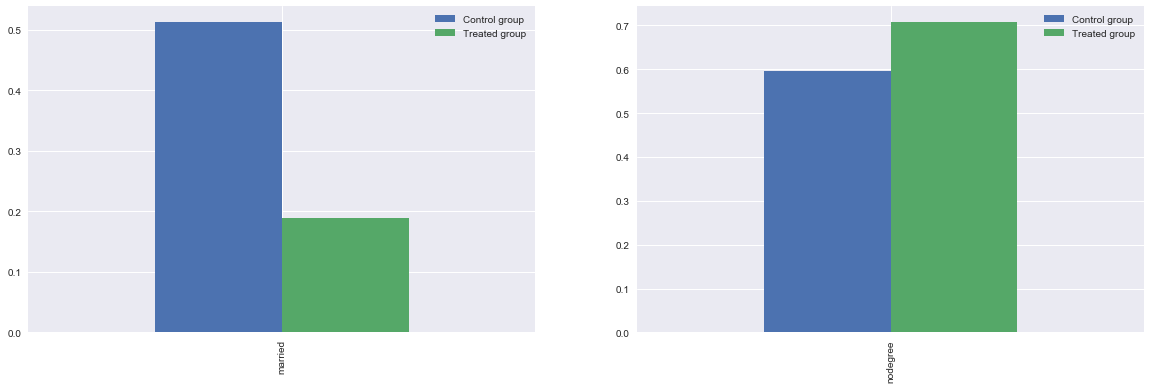

In [333]:
def plot_categorical_distribution( df ) : 
    """

    """
    f, ax = plt.subplots(1, figsize = (20,6))
    f.suptitle("Feature- value distribution between the treated and control group", fontsize=18)
    
    ### race
    race = pd.pivot_table(df, values=['black','hispan'], columns=['treat'])
    race.loc['white'] = 1 - (race.loc['black'] + race.loc['hispan'])
    race.plot(kind='bar', ax=ax)
    
    ax.legend(["Control group","Treated group"])
    
    f, ax = plt.subplots(nrows=1,ncols=2, figsize = (20,6))
    ### mariage
    married = pd.pivot_table(df, values=['married'], columns=['treat'])
    married.plot(kind='bar', ax=ax[0])
    
    ### degree
    degree = pd.pivot_table(df, values=['nodegree'], columns=['treat'])
    degree.plot(kind='bar', ax=ax[1])

    
    ax[0].legend(["Control group","Treated group"])
    ax[1].legend(["Control group","Treated group"])
    
plot_categorical_distribution(lalonde)

- #####  Race distribution: 
We can see that the distribution per race is not the same at all. Even if the US racial segregation officialy stoped in 1967, we can assume that the race is still an important metric in the 70's.
- #### Mariage distribution:
The difference between the two groups is huge, 51% for the control group and only 19% for the treated group. We can easily imagine that the mariage can have a huge effect on on the real earnings of an individual. 
- #### Degree distribution
The percentage of individuals who has a degree is very different in the 2 groups. It could definitely affect the result of the study.
#### Education distribution

In [302]:
lalonde.groupby('treat')['educ'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,10.235431,2.855238,0.0,9.0,11.0,12.0,18.0
1,185.0,10.345946,2.010650,4.0,9.0,11.0,12.0,16.0


It is interestikng to see that the mean and the variation are quite similar. Now let's take a look on the distribution.

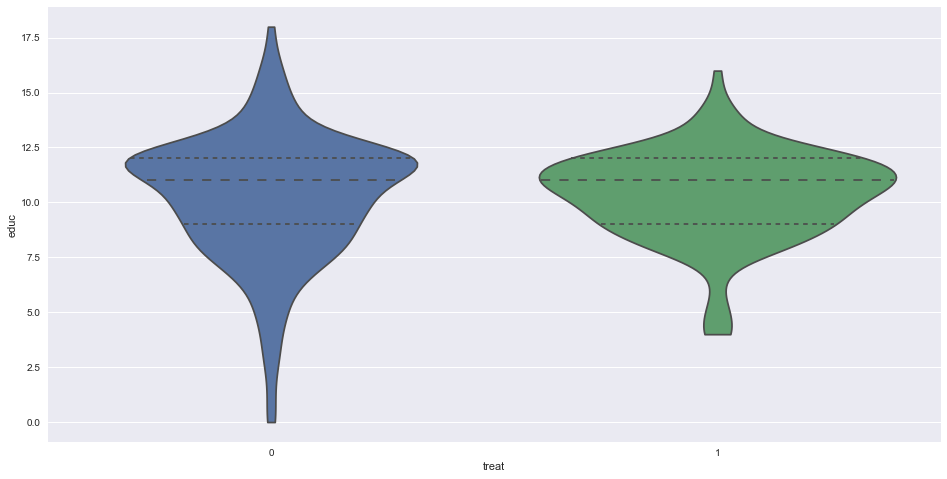

In [303]:
plot_distribution(lalonde,'educ','Education distribution')

The distribution is quite similar but we can see that the distribution of the treated group is more centered around the mean while the distribution of the control group is way more extanded. The extremum could have a huge importance on the study.

#### Summary

We can notice that some metrics have a really differente distribution. But we noticed that the 2 main diferences are about the **race** and **the unemployement**. We will use those two metrics on the part 5.


### 3. A propsensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [304]:
def compute_propensity(df) : 
    """
    Function to compute the propensity score
    of the entire dataset given as parameter
    """

    # Create the model 
    logistic = LogisticRegression() 
    X = df.loc[:, df.columns != 'treat']
    y = df.treat
    # Train the model
    logistic.fit(X, y)

    prediction = logistic.predict_proba(X)

    df['propensity_score'] = pd.Series(logistic.predict_proba(X)[:, 0],index=df.index)

    return df

In [305]:
lalonde = compute_propensity(lalonde)
lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.523005
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.859473
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.235143
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.304991
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.326129



Let's plot the distribution of the protensity score.

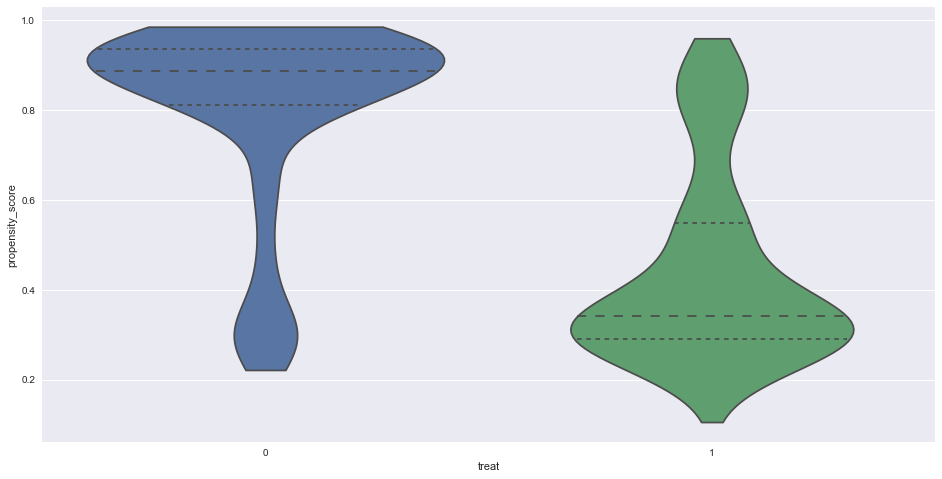

In [306]:
control_group=lalonde[lalonde.treat==0]
treated_group=lalonde[lalonde.treat==1]

df = control_group.append(treated_group)

plot_distribution(df,'propensity_score','Propensity score distribution')

### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [368]:
import networkx as nx

def match( df) :
    """
    Function to match each data point from the treated group
    with exactly one data point from the control group 
    """
    
    control_group=df[df.treat==0]
    treated_group=df[df.treat==1]

    graph_matches = nx.Graph()

    for control_index, control_row in control_group.iterrows():
        graph_matches.add_node(control_index)
        for treated_index, treated_row in treated_group.iterrows():
            graph_matches.add_node(treated_index)
            # compute the weight
            # 1 - distance
            weight = 1 - np.abs(treated_row.propensity_score - control_row.propensity_score)
            graph_matches.add_edge(control_index, treated_index, weight=weight)

    matches_list = nx.max_weight_matching(graph_matches)

    matched = pd.DataFrame()
    for key,value in matches_list.items():
        matched = matched.append(df.loc[key])

    return matched

In [367]:
data = match( lalonde)
data.head()

KeyboardInterrupt: 

As we can see, after the matching the distribution is a little bit fairer but we still can see huge difference for the race and the unemployment.  #TODO add description

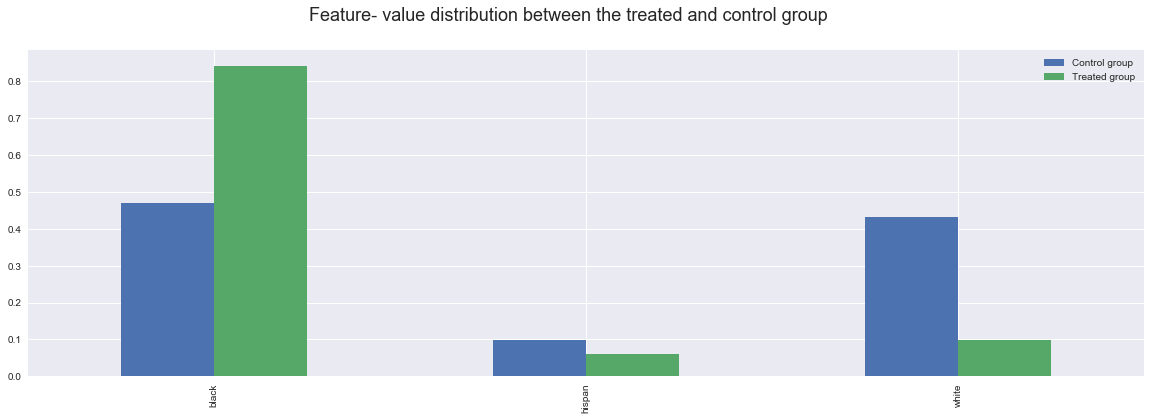

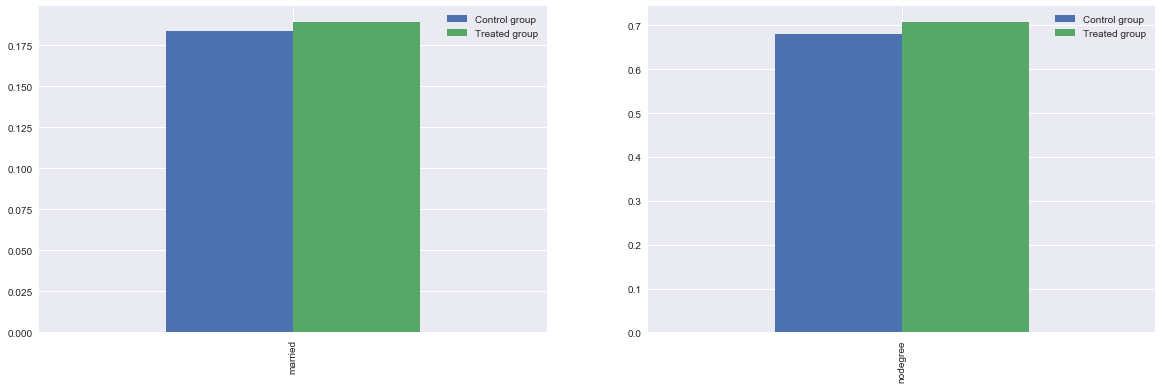

In [334]:
plot_categorical_distribution( data )

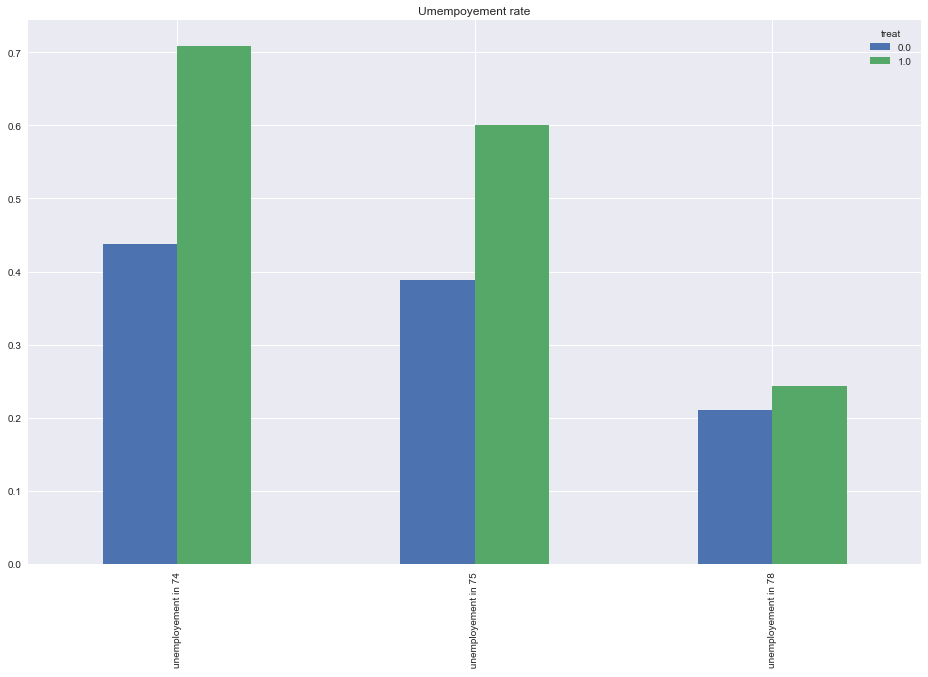

In [350]:
unemployement(data).plot()

In [380]:
data.groupby('treat')['re78'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0.0,185.0,6196.171329,6531.895494,0.0,237.9140,4520.366,9438.240,25564.67
1.0,185.0,6349.143530,7867.402218,0.0,485.2298,4232.309,9642.999,60307.93


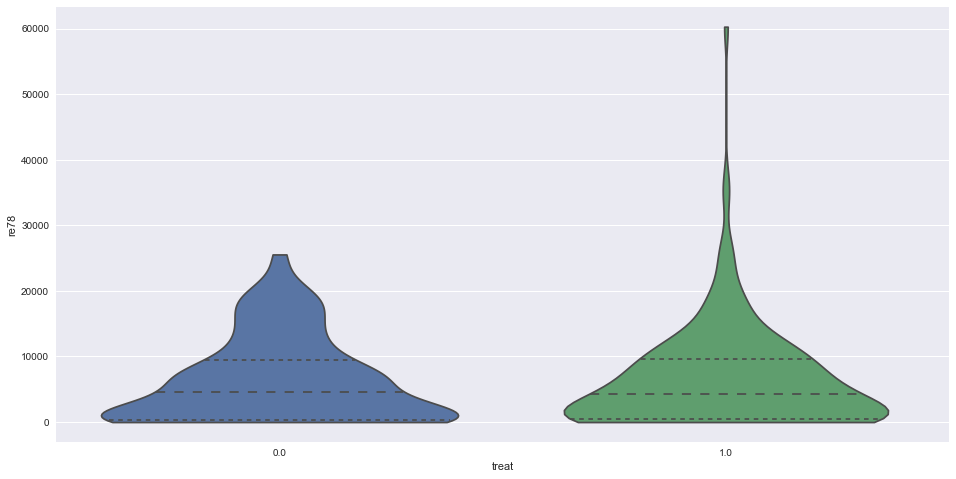

In [381]:
plot_distribution(data,'re78','Matched distribution')

#TODO add description
### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


#### Process

The matching done in Part 4 shows that the dataset is now better balanced than in Part 2. The balance of race between the control and treated groups can still be improved. There is still more black people in the treated group than in the control group and the major part of the white subjects are part of the control group.

From part 4, we have evaluated the **race as the problematic feature**.

In order to better balance the datatset, we will match : 
- exactly 1 black person on the control group to 1 black person on the treated group
- exactly 1 non black person on the control group to 1 non black person on the treated group

In [375]:
"""
Match only black people
"""
black_unemployed = data[(data['black'] == 1) & (data['re75'] == 0)]
matched_black_unemployed = match(black_unemployed)

"""
Match only black people
"""
black_non_unemployed = data[(data['black'] == 1) & (data['re75'] > 0)]
matched_black_non_unemployed = match(black_non_unemployed)


"""
Match not black people
"""
not_black_unemployed = data[data['black'] == 0 & (data['re75'] == 0)]
matched_not_black_unemployed = match(not_black_unemployed)

"""
Match not black people
"""
not_black_non_unemployed = data[data['black'] == 0 & (data['re75'] > 0)]
matched_not_black_non_unemployed = match(not_black_non_unemployed)


"""
Build a better balanced dataset
"""
matched = matched_black_unemployed.append([matched_black_non_unemployed,
                                           matched_not_black_unemployed,
                                           matched_not_black_non_unemployed])

In [377]:
matched.groupby('treat')['re78'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0.0,145.0,5334.388978,6582.180860,0.0,0.0000,2284.565,7933.914,25564.67
1.0,145.0,6201.680911,6431.918719,0.0,672.8773,4814.627,9970.681,36646.95


We have narrowed down the dataset to **145 subjects on each groups** instead of 185 on the previous dataset.
The description of the dataset above clearly shows that the race of the subject has a major influence on the earning. Since our dataset was not balanced we couldn't have an efficient representation. With a better balanced dataset we can clearly see that salary of subjects from the treated group ( mean = 6201 )  is higher than people from the control group ( mean = 5334 ). 

We can see that the two groups are better balanced by plotting the feature-value distribution, as we did above in part 2 and 4.

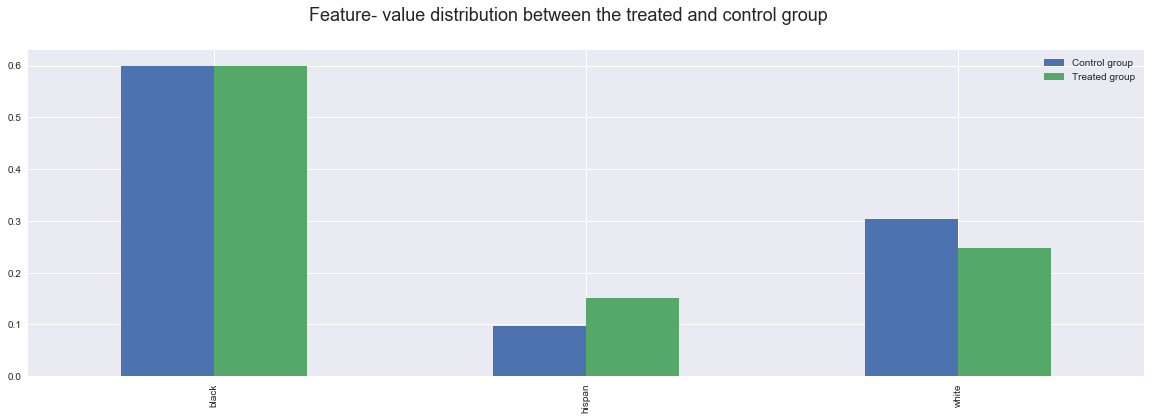

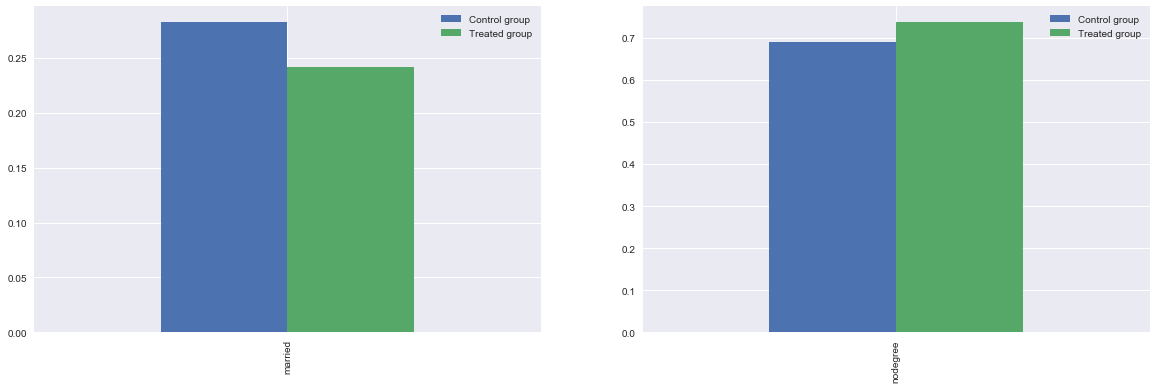

In [378]:
plot_categorical_distribution( matched )


### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

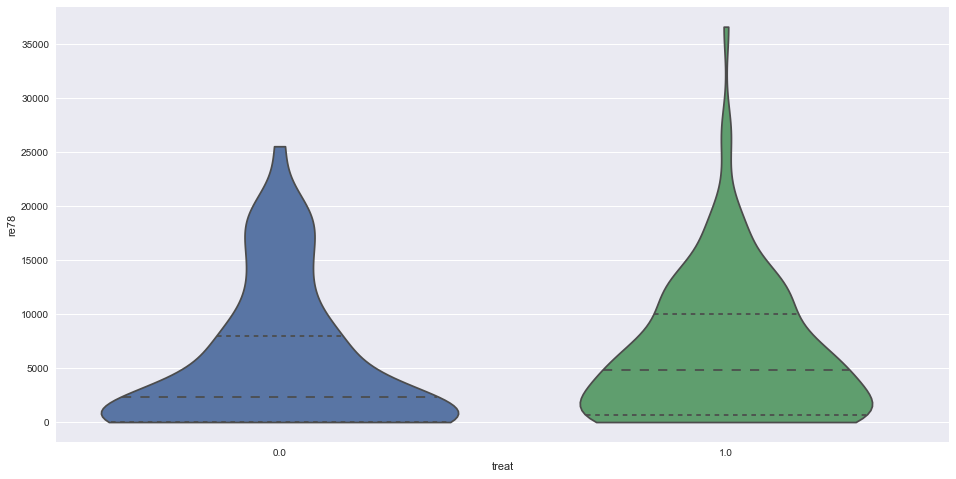

In [379]:
plot_distribution(matched,'re78','Matched distribution')

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

### Task 1
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.cross_validation import train_test_split

from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from random import randrange
from sklearn.ensemble import RandomForestClassifier

#### Load the data

In [ ]:
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

#### Compute TF-IDF features for every article using TfidfVectorizer

In [ ]:
categories = newsgroups.target_names
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups.data)
print("shape = {0}".format(vectors.shape))
print("Number of non-zero components by sample = {0}".format(vectors.nnz / float(vectors.shape[0])))

The extracted TF-IDF vectors are very sparse, with an average of 97 non-zero components by sample in a more than 100000-dimensional space (less than 0.1% non-zero features):

#### Split the dataset into a training, a testing and a validation set

In [ ]:
# this is a test...
text_pairs = []
for i in range(vectors.shape[0]):
    text_pairs.append([newsgroups.data[i],categories[newsgroups.target[i]]])

train_text, test_text = train_test_split(text_pairs, test_size=.2)
test_text, validation_text = train_test_split(test_text, test_size=.5)

### Task 2
Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.